# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2025

##### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook .ipynb notebook and as a PDF-file made from it. Please, add your full name to the file name.
    - The exercise will be graded by a maximum of 2 points.
    - Submit to moodle your solution on ** Wednesday 5 of February ** at the latest.
  

## Import libraries

In [1]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
from scipy.stats import somersd

from sklearn.model_selection import LeaveOneOut, GroupKFold
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p> 

In the following cell: 
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [3]:
data = pd.read_csv('water_data.xls')

# Print the dimensions of the dataset
num_rows, num_columns = data.shape
print(f"Dataset dimensions: {num_rows} rows, {num_columns} columns")

# Display the first 5 rows
print("First 5 rows of the dataset:")
data.head()

Dataset dimensions: 225 rows, 6 columns
First 5 rows of the dataset:


,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,0.0,0.0,0.0,-0.999216,-0.714208,-0.414911
1,0.0,0.0,0.0,-0.990800,-0.714373,-0.238335
2,0.0,0.0,0.0,-0.990539,-0.714125,0.020788
3,14.0,0.0,14.0,-1.001247,-0.713546,0.945465
4,14.0,0.0,14.0,-1.013727,-0.714125,0.569631


In [4]:
# Identify the input and output columns
# In my opinnion the output values are variables that we want to predict: c_total, Cd, Pb
# And the input values arte the variables that we use for prediction: Mod1, Mod2, Mod3

data_columns = data.columns.tolist()
inputs = data_columns[3:] 
output = data_columns[:3] 

print(f"Input columns: {inputs}")
print(f"Output column: {output}")

# Group by unique mixtures based on the output columns and count replicas
grouped = data.groupby(output).size()

# Count the number of mixtures with different amount of replicas
replica_counts = grouped.value_counts()

replica_counts

Input columns: ['Mod1', 'Mod2', 'Mod3']
Output column: ['c_total', 'Cd', 'Pb']


3    43
4    24
Name: count, dtype: int64

## C-index code 

In [5]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

## Functions

From https://scikit-learn.org/stable/modules/neighbors.html I followed the instructions and examples for nearest neighbors regression and from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html I used instructions for GroupKFold function: K-fold iterator variant with non-overlapping groups. 
Each group will appear exactly once in the test set across all folds (the number of distinct groups has to be at least equal to the number of folds I asumed that th replicas are the groups.).

In [6]:
# Preparing data
X = data[inputs].values
y_c_total = data['c_total'].values
y_Cd = data['Cd'].values
y_Pb = data['Pb'].values

# Number of neighbors to test
k_values = [1, 3, 5, 7]

In [7]:
# In this cell add the functions that you need for the data analysis part.

# Leave-One-Out Cross-Validation (LOOCV)
def loocv_knn(X, y, k_values):
    loo = LeaveOneOut()
    c_index_results = {k: [] for k in k_values}

    #A KNN model is created for each k value.
    #A placeholder array preds is initialized to store predictions.

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
        preds = np.zeros_like(y, dtype=float)

        # The dataset is split into training and testing sets, where one sample is used as a test set at a time.
        # The model is trained on N-1 samples and tested on the remaining 1.
        # The predicted value for the test sample is stored in preds.
        
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]
            knn.fit(X_train, y_train)
            preds[test_index] = knn.predict(X_test)

        # After predicting all values, the C-index (which measures ranking quality) is computed and stored.
        c_index_results[k].append(cindex(y, preds))
    return c_index_results

# Leave-Replicas-Out Cross-Validation (LROCV)
def lrocv_knn(X, y, groups, k_values):

    # GroupKFold ensures that entire groups are used for either training or testing, preventing bias.
    group_kfold = GroupKFold(n_splits=len(np.unique(groups)))
    c_index_results = {k: [] for k in k_values}

    # Creates a KNN model for each k value and initializes a prediction array.
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
        preds = np.zeros_like(y, dtype=float)

        # Instead of splitting individual data points, entire groups are separated into training and testing sets.
        # The model is trained on one set of groups and tested on another.

        for train_index, test_index in group_kfold.split(X, y, groups=groups):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]
            knn.fit(X_train, y_train)
            preds[test_index] = knn.predict(X_test)

        c_index_results[k].append(cindex(y, preds))
    return c_index_results


## Results for Leave-One-Out cross-validation

In [8]:
# Here run your script for Leave-One-Out cross-validation and print the corresponding results.

# Calculate LOOCV and LROCV results for each output
loocv_results = {
    "c_total": loocv_knn(X, y_c_total, k_values),
    "Cd": loocv_knn(X, y_Cd, k_values),
    "Pb": loocv_knn(X, y_Pb, k_values),
}


loocv_results

{'c_total': {1: [0.9082833811137173],
  3: [0.9141907740422205],
  5: [0.8941012944140387],
  7: [0.8737294761532447]},
 'Cd': {1: [0.921869127656909],
  3: [0.8995907629348143],
  5: [0.8619660082682591],
  7: [0.8141520858562659]},
 'Pb': {1: [0.8805487117384223],
  3: [0.8744519146448406],
  5: [0.8542614941328768],
  7: [0.8355326345680043]}}

## Results for Leave-Replicas-Out cross-validation

In [9]:
# Here run your script for Leave-Replicas-Out cross-validation and print the corresponding results.

# Define groups based on the unique mixtures (replicas)
groups = data.groupby(output).ngroup()

lrocv_results = {
    "c_total": lrocv_knn(X, y_c_total, groups, k_values),
    "Cd": lrocv_knn(X, y_Cd, groups, k_values),
    "Pb": lrocv_knn(X, y_Pb, groups, k_values),
}

lrocv_results

{'c_total': {1: [0.8184128225175918],
  3: [0.8186734427938493],
  5: [0.8117018504039615],
  7: [0.8163712970202415]},
 'Cd': {1: [0.7784273604209295],
  3: [0.7614523739925669],
  5: [0.7397168747651063],
  7: [0.7153088069486784]},
 'Pb': {1: [0.7377750866496847],
  3: [0.7689480937069362],
  5: [0.7478389777425147],
  7: [0.7618490833924918]}}

## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

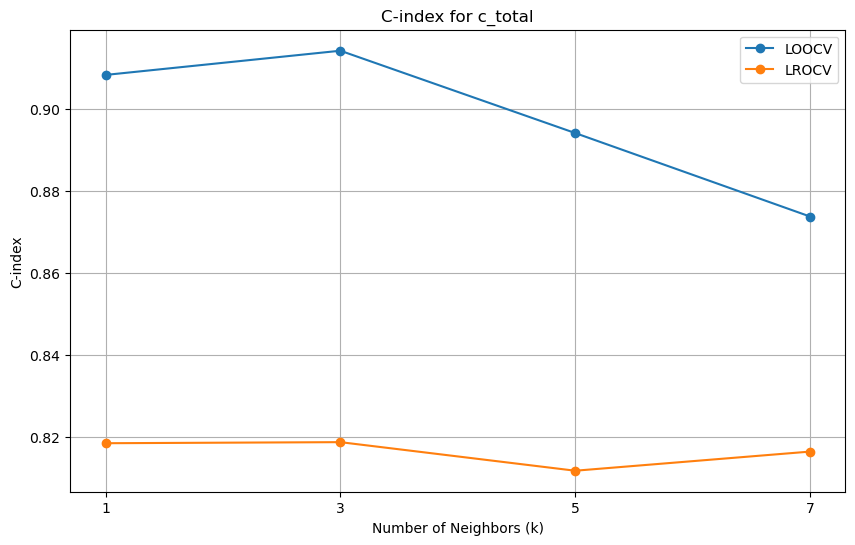

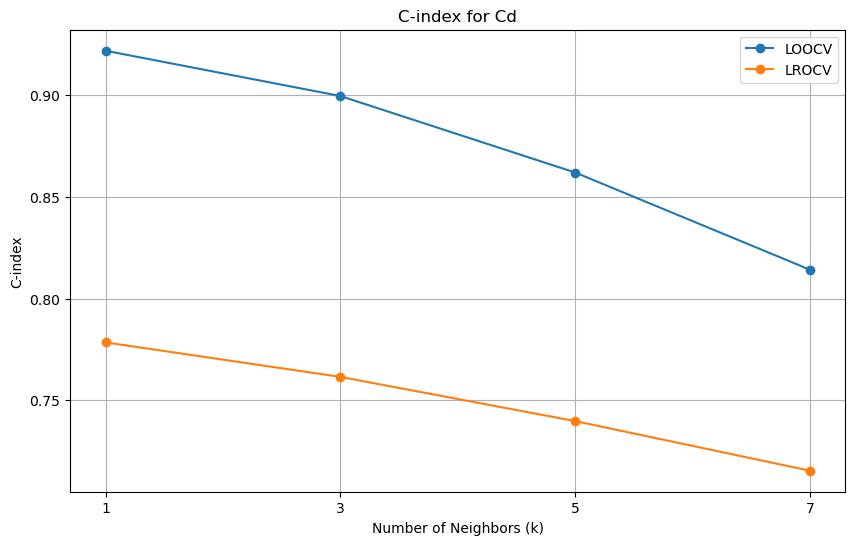

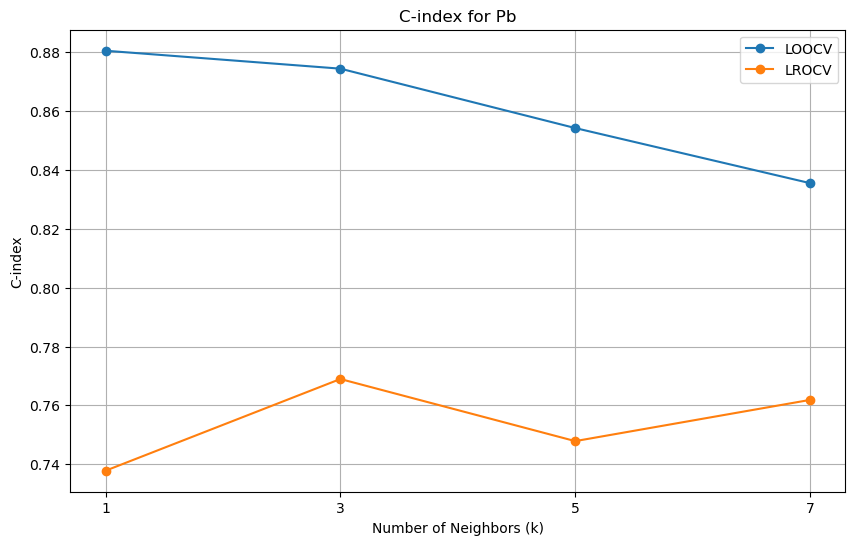

In [10]:
# Function to plot results
def plot_results(loocv_results, lrocv_results, k_values, title):
    plt.figure(figsize=(10, 6))

    # Plot LOOCV results
    loocv_scores = [loocv_results[k][0] for k in k_values]
    plt.plot(k_values, loocv_scores, label='LOOCV', marker='o')

    # Plot LROCV results
    lrocv_scores = [lrocv_results[k][0] for k in k_values]
    plt.plot(k_values, lrocv_scores, label='LROCV', marker='o')

    plt.title(title)
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("C-index")
    plt.xticks(k_values)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot results for c_total, Cd, and Pb
plot_results(loocv_results["c_total"], lrocv_results["c_total"], k_values, "C-index for c_total")
plot_results(loocv_results["Cd"], lrocv_results["Cd"], k_values, "C-index for Cd")
plot_results(loocv_results["Pb"], lrocv_results["Pb"], k_values, "C-index for Pb")


## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:



1. Which cross-validation approach produced more optimistic results, and why?

LOOCV (Leave-One-Out Cross-Validation) produced more optimistic results because it consistently yields higher C-index values compared to LROCV (Leave-Replicas-Out Cross-Validation). This happens because LOOCV uses almost all data points for training and only one point for testing at each iteration, leading to a model that is highly trained on almost all available data. As a result, LOOCV tends to mabey overestimate performance, making it look more optimistic.

2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

LROCV (Leave-Replicas-Out Cross-Validation) provides a better estimate of the model's performance on unseen data. Unlike LOOCV, which only leaves out a single sample, LROCV ensures that entire groups (replicas) of data points are left out at a time. This better simulates how the model will perform on entirely new, unseen mixtures, making it a more realistic estimate of generalization. Since real-world data often comes in grouped batches (e.g., different experiments, different environmental conditions), LROCV helps avoid data leakage and gives a more reliable performance estimate.
